In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Building Demand in GCAM
The following is my attempt to follow GCAM's method for calculating energy demand for buildings

### Constants

In [2]:
# Satiation level of floor space demand (I chose these based off the historical data)
S_FS_R = 65
S_FS_C = 24

# Price elasticity of energy services (all GCAM provides for the building sector is 'Fuel preference elasticies', so I averaged those)
BETA_R = -0.630769230769231
BETA_C = -0.381818181818182

# Ratio of building surface area to floorspace area (no idea about this one, 
# I simply did (4 walls + 1 ceiling)/1 floor, considering all to be the same area (which is ridiculous but whatever)
R = 5

# Historical years
HIST_YEARS = list(range(2000, 2019))

# Projection time horizon (5 year steps)
PROJ_YEARS = list(range(2020, 2101, 5))

### Import data from excel sheet
This includes historical data for residential and commercial floor space, as well as data for residential/commercial space heating/cooling

In [101]:
data = pd.read_excel('data.xlsx',
                     sheet_name = 'data',
                     usecols = ['region', 'variable', 'year', 'value', 'unit'])
data.set_index(['variable', 'year'], inplace = True)
data = data[['value', 'unit']]

# Import historical floorspace demand data
res_floor_hist = data.loc[('res_floor_demand', slice(None)), :]
com_floor_hist = data.loc[('com_floor_demand', slice(None)), :]

# Import historical space heating and cooling demand data
res_heat_hist = data.loc[('res_heat_intensity', slice(None)), :]
res_cool_hist = data.loc[('res_cool_intensity', slice(None)), :]
com_heat_hist = data.loc[('com_heat_intensity', slice(None)), :]
com_cool_hist = data.loc[('com_cool_intensity', slice(None)), :]

# Income
income_hist = data.loc[('income', HIST_YEARS), :]
income2018 = float(income_hist.loc[('income', 2018)]['value'])
income_proj = data.loc

## Historical Plotting

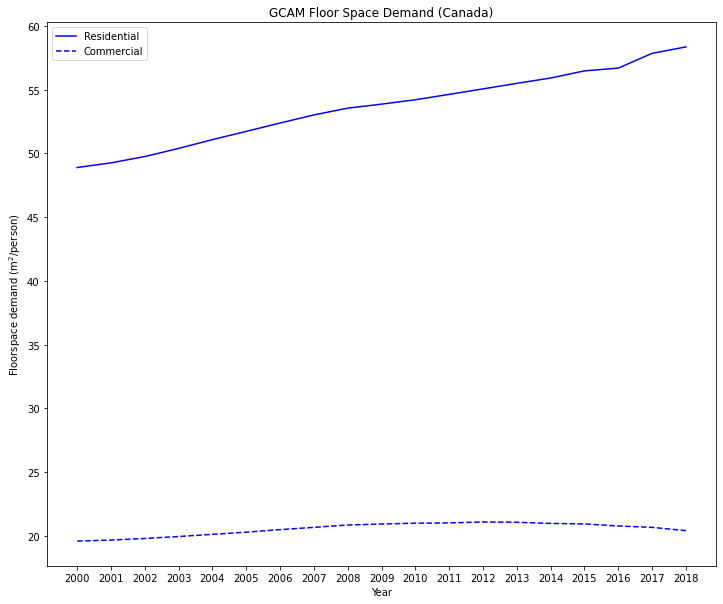

In [107]:
# Want to plot both residential and commercial historical demand here
fig, ax = plt.subplots(figsize = (12, 10))
ax.set_xticks(HIST_YEARS)
ax.plot(HIST_YEARS, res_floor_hist['value'],
        label = 'Residential',
        c = 'blue')
ax.plot(HIST_YEARS, com_floor_hist['value'],
        label = 'Commercial',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(title = 'Floor Space Demands (Canada)',
       xlabel = 'Year',
       ylabel = 'Floorspace demand (m$^2$/person)');

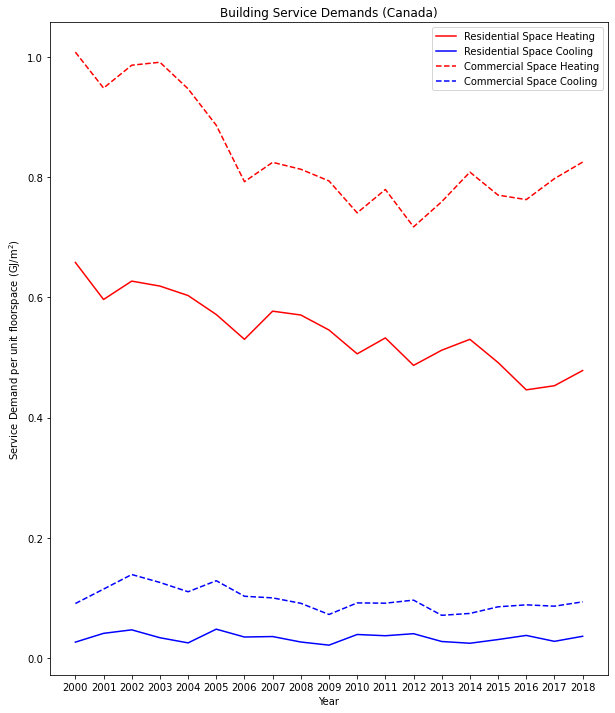

In [109]:
fig, ax = plt.subplots(figsize = (10, 12))
ax.set_xticks(HIST_YEARS)
ax.plot(HIST_YEARS, res_heat_hist['value'],
        label = 'Residential Space Heating',
        c = 'red')
ax.plot(HIST_YEARS, res_cool_hist['value'],
        label = 'Residential Space Cooling',
        c = 'blue')
ax.plot(HIST_YEARS, com_heat_hist['value'],
        label = 'Commercial Space Heating',
        c = 'red',
        ls = '--')
ax.plot(HIST_YEARS, com_cool_hist['value'],
        label = 'Commercial Space Cooling',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(title = 'Building Service Demands (Canada)',
       xlabel = 'Year',
       ylabel = 'Service Demand per unit floorspace (GJ/m$^2$)');

## Base year calibration
For simplicity's sake I assume negligible change between 2018 and 2020, and use 2018 values for my 2020 base projection year

### Floor space

In [7]:
res_floor2018 = float(res_floor_hist.loc[(slice(None), 2018),:]['value'])
com_floor2018 = float(com_floor_hist.loc[(slice(None), 2018),:]['value'])

### Residential/Commercial Service Demands

In [8]:
res_heat2018 = float(res_heat_hist.loc[(slice(None), 2018), :]['value'])
res_cool2018 = float(res_cool_hist.loc[(slice(None), 2018), :]['value'])
com_heat2018 = float(com_heat_hist.loc[(slice(None), 2018), :]['value'])
com_cool2018 = float(com_cool_hist.loc[(slice(None), 2018), :]['value'])

### Internal Gains
Clarke et al: "Internal gains are calculated in each region as 50% of the sum of all fuel consumption used for 'other' (not heating or cooling) services

In [9]:
res_ig = data.loc[('res_other_intensity/2', slice(None)), :]
com_ig = data.loc[('com_other_intensity/2', slice(None)), :]

IG_R2018 = float(res_ig.loc[(slice(None), 2018), :]['value'])
IG_C2018 = float(com_ig.loc[(slice(None), 2018), :]['value'])

# Since the internal gain scaler is not specified in
# Clarke et al, I used the number of summer and winter months to find it
# Summer months: [May: August] inclusive
# Winter months: [November:February] inclusive
# So, ratio of summmer months to total = 1/3
# and ratio of winter to total = 1/3
# So when space cooling is calculated, IG applies 1/3 of the time (summer months)
# Same for space heating

### Shell Conductivity (U-value)
Given in Fig S3 of Clarke et al

In [10]:
eta = np.linspace(0.95, 0.7, len(PROJ_YEARS))

### HDD/CDD
Start with reference scenario, in which HDD and CDD do not change over the model horizon

In [11]:
HDD = 4300
CDD = 200

### Satiated demand
"The satiation level is assumed to be the maximum of the actual observed base-year demand levels, and the satiation level in the USA for the corresponding sector and service, modified for the HDD/CDD difference" (pp. 10 of supplementary to Clarke et al)

In [12]:
S_CAN = lambda S_USA, DD_CAN, DD_USA: S_USA*(DD_CAN/DD_USA)

# HDD/CDD collected from pp. 672
HDD_USA = 2500
CDD_USA = 800

# Satiation levels collected from pp. 11 of supplementary
S_USA_RH = 0.24
S_USA_CH = 0.25
S_USA_RC = 0.16
S_USA_CC = 0.29

# Residential heating
S_RH = max(res_heat2018, S_CAN(S_USA_RH, HDD, HDD_USA))

# Residential cooling
S_RC = max(res_cool2018, S_CAN(S_USA_RC, CDD, CDD_USA))
           
# Commercial heating
S_CH = max(com_heat2018, S_CAN(S_USA_CH, HDD, HDD_USA))
           
# Commercial cooling
S_CC = max(com_cool2018, S_CAN(S_USA_CC, CDD, CDD_USA))

### Find K

In [13]:
# 1/3 is my internal gain scaler, detailed above in 'Internal Gains' section
K = lambda S, DD, IG : S/(DD*eta[0]*R*1/3*IG)

In [31]:
# Res heat
K_RH = K(S_RH, HDD, IG_R2018)

# Res cool
K_RC = K(S_RC, CDD, IG_R2018)

# Com heat
K_CH = K(S_CH, HDD, IG_C2018)

# Com cool
K_CC = K(S_CC, CDD, IG_C2018)

### Energy service price averages
Fig 6 (pp. 674)

In [15]:
## Both residential and commerical space heating are assumed to be relatively constant over the projection range

# Create lists to hold prices
p_res_heat = np.array([20]*len(PROJ_YEARS))
p_res_cool = np.zeros(len(PROJ_YEARS))
p_com_heat = np.array([30]*len(PROJ_YEARS))
p_com_cool = np.zeros(len(PROJ_YEARS))

# Residential
# 5-year rate of change for residential space cooling
res_cool_rate = (1 - 0.22)**(1/len(PROJ_YEARS))

# Commercial
# 5-year rate of change for commercial space cooling
com_cool_rate = (1 - 0.28)**(1/len(PROJ_YEARS))

# Initial values from Fig. 6 in Clarke et al.
p_res_cool[0] = 38
p_com_cool[0] = 21

# Generate cooling trajectories
for index in range(1, len(PROJ_YEARS)):
    p_res_cool[index] = p_res_cool[index - 1] * res_cool_rate
    p_com_cool[index] = p_com_cool[index - 1] * com_cool_rate

p_res = p_res_heat + p_res_cool
p_com = p_com_heat + p_com_cool

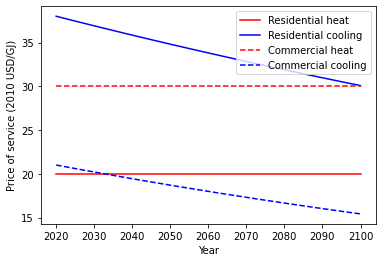

In [16]:
# Plot of prices
fig, ax = plt.subplots()
# ax.plot(proj_years, p_res_heat)
ax.plot(PROJ_YEARS, p_res_heat, color = 'r', label = 'Residential heat')
ax.plot(PROJ_YEARS, p_res_cool, color = 'b', label = 'Residential cooling')
ax.plot(PROJ_YEARS, p_com_heat, linestyle = '--', color = 'r', label = 'Commercial heat')
ax.plot(PROJ_YEARS, p_com_cool, linestyle = '--', color = 'b', label = 'Commercial cooling')
plt.xlabel('Year')
plt.ylabel('Price of service (2010 USD/GJ)')
plt.legend()
plt.show()

### Find mu

In [26]:
np.log(1-(res_heat2018/((K_RH*HDD*eta[0]*R)-(IG_R2018/3))))

-0.04297403964026611

In [35]:
mu = lambda p, d, K, DD, IG : -(np.log(2)*income2018)/(p*np.log(1-(d/(K*((DD*eta[0]*R)-(IG/3))))))

MU_RH = mu(p_res_heat[0], res_heat2018, K_RH, HDD, IG_R2018)
MU_RC = mu(p_res_cool[0], res_cool2018, K_RC, CDD, IG_R2018)
MU_CH = mu(p_com_heat[0], com_heat2018, K_CH, HDD, IG_C2018)
MU_CC = mu(p_com_cool[0], com_cool2018, K_CC, CDD, IG_C2018)

## Projections

### Income

In [88]:
# Projection data
income_proj = data.loc[('proj_income', PROJ_YEARS), :]['value']

### Floor space

In [ ]:
# First we find mu (income at 50% of satiation)
mu_r = -(np.log(2)*income2015)/np.log(1 - res_floor2018/S_R)
mu_c = -(np.log(2)*income2015)/np.log(1 - com_floor2018/S_C)

# Function for calculating floor space demand given in GCAM docs
FS = lambda S, MU, I, P, P_0, BETA : (S - a) * ((1 - np.exp(-(np.log(2)/MU) * I * (P/P_0)**BETA)) + a)

res_floor_proj = np.zeros(len(PROJ_YEARS))
com_floor_proj = np.zeros(len(PROJ_YEARS))

a = 0

for index in range(0, len(PROJ_YEARS)):
    res_floor_proj[index] = FS(s_r, mu_r, income_proj['value'].tolist()[index], p_res[index], p_res[0])
    com_floor_proj[index] = FS(s_c, mu_c, income_proj['value'].tolist()[index], p_com[index], p_com[0])

### Space heating/cooling

In [54]:
D = lambda K, DD, eta, IG, I, MU, p: K*((DD*eta*R)-(IG/3))*(1-np.exp(-(np.log(2)*I)/(MU*p)))

res_heat_proj = np.zeros(len(PROJ_YEARS))
res_cool_proj = np.zeros(len(PROJ_YEARS))
com_heat_proj = np.zeros(len(PROJ_YEARS))
com_cool_proj = np.zeros(len(PROJ_YEARS))

for x in range(0, len(PROJ_YEARS)):
    res_heat_proj[x] = D(K_RH, HDD, eta[x], IG_R2018, income_proj[x], MU_RH, p_res_heat[x])
    res_cool_proj[x] = D(K_RC, CDD, eta[x], IG_R2018, income_proj[x], MU_RC, p_res_cool[x])
    com_heat_proj[x] = D(K_CH, HDD, eta[x], IG_C2018, income_proj[x], MU_CH, p_com_heat[x])
    com_cool_proj[x] = D(K_CC, CDD, eta[x], IG_C2018, income_proj[x], MU_CC, p_com_cool[x])

### Plotting

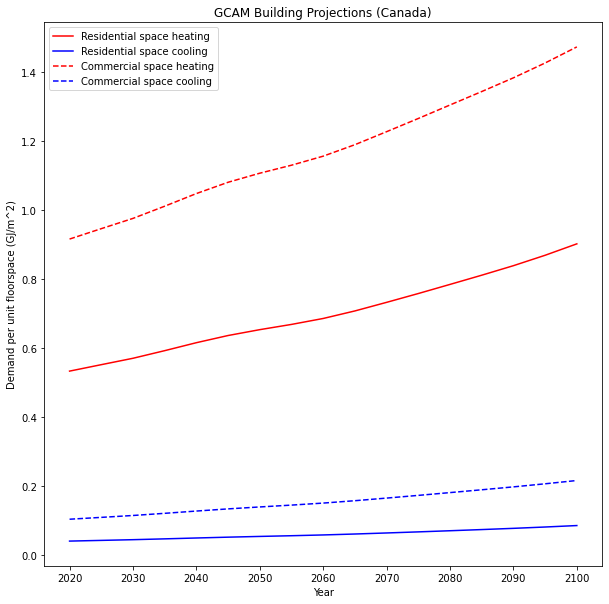

In [83]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(PROJ_YEARS, res_heat_proj, label = 'Residential space heating',
        c = 'red',
        )
ax.plot(PROJ_YEARS, res_cool_proj, label = 'Residential space cooling',
        c = 'blue')
ax.plot(PROJ_YEARS, com_heat_proj, label = 'Commercial space heating',
        c = 'red',
        ls = '--')
ax.plot(PROJ_YEARS, com_cool_proj, label = 'Commercial space cooling',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(title = 'GCAM Building Projections (Canada)',
       xlabel = 'Year',
       ylabel = 'Demand per unit floorspace (GJ/m^2)');

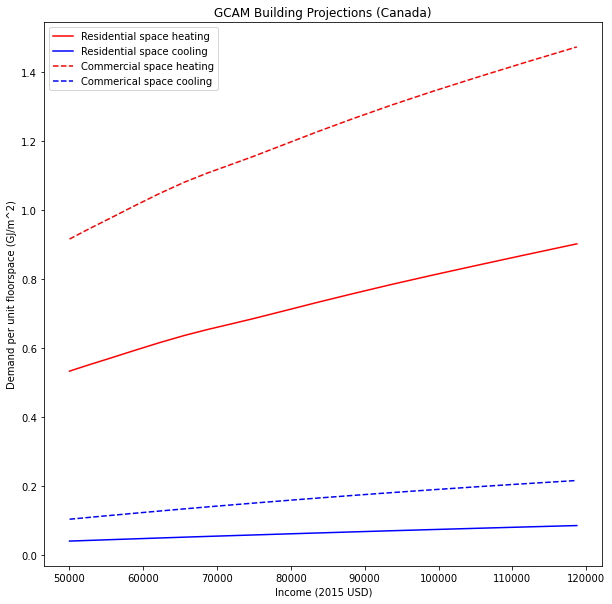

In [82]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(income_proj, res_heat_proj,
        label = 'Residential space heating',
        c = 'red')
ax.plot(income_proj, res_cool_proj,
        label = 'Residential space cooling',
        c = 'blue')
ax.plot(income_proj, com_heat_proj,
        label = 'Commercial space heating',
        c = 'red',
        ls = '--')
ax.plot(income_proj, com_cool_proj,
        label = 'Commerical space cooling',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(title = 'GCAM Building Projections (Canada)',
       xlabel = 'Income (2015 USD)',
       ylabel = 'Demand per unit floorspace (GJ/m^2)');

# Testing

In [5]:
elas = pd.read_csv('elasticities.csv',
                   index_col = ['sector', 'technology'])

In [ ]:


elas.loc[()]

In [11]:
elas.groupby(level = 'sector').mean()

,fuelprefElasticity
sector,
comm,-0.381818
comm cooling,-0.500000
comm heating,-0.175000
comm others,-0.500000
resid,-0.630769
resid cooling,-0.500000
resid heating,-0.540000
resid others,-0.750000


# OLD CODE

In [ ]:
# Historical
income_hist_list = income_hist[income_hist['year'] <= 2015]['value'].tolist()
res_floor_hist_list = res_floor_hist[res_floor_hist['year'] <= 2015]['value'].tolist()
com_floor_hist_list = com_floor_hist[com_floor_hist['year'] <= 2015]['value'].tolist()
fig, ax = plt.subplots(figsize = (8, 10))
ax.plot(income_hist_list, res_floor_hist_list, color = 'blue', label = 'Residential floor space demand')
ax.plot(income_hist_list, com_floor_hist_list, color = 'orange', label = 'Commercial floor space demand')
plt.legend()
plt.show()

# Projection
income_proj_list = income_proj['value'].tolist()
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(income_proj_list, res_floor_proj, color = 'blue', label = 'Residential floor space projection')
ax.scatter(income_proj_list, res_floor_proj, color = 'black')
ax.plot(income_proj_list, com_floor_proj, color = 'orange', label = 'Commercial floor space projection')
ax.scatter(income_proj_list, com_floor_proj, color = 'black')
for i, label in enumerate(proj_years):
    plt.annotate(label, (income_proj_list[i], com_floor_proj[i]))
plt.xlabel('Income (2015USD/cap)')
plt.ylabel('Residential floor space demand (m^2/cap)')
plt.legend()
plt.show()

In [ ]:
### Service demand for each technology

tech_costs = pd.read_csv('building_costs.csv',
                        usecols = ['sector|supplysector', 'technology', 'installed cost (2015 USD)', 'lifetime', 'O&M cost (2015 USD)', 'efficiency', 'UEC'],
                        ).rename(columns = {'sector|supplysector': 'sector|service'})

# Index by sector|service
tech_costs = tech_costs.set_index(['sector|service', 'technology']).sort_index()

# Multiplying efficiency and consumption to find tech service demands
tech_costs['service demand'] = tech_costs['efficiency'] * tech_costs['UEC']

# Aggregate data for each sector|service combination
indices = list(tech_costs.index)
services = set([x[0] for x in indices])
sums = [x for x in tech_costs.columns if x != 'lifetime' and x != 'efficiency']

for x in services:
    tech_costs.loc[(x, 'all'), sums] = tech_costs.loc[(x, slice(None)), sums].sum()

tech_costs.sort_index(inplace = True)

tech_costs

tech_costs.loc[(slice(None), 'all'),'service demand']